In [1]:
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

import torch.utils.data
from torch.utils.data import DataLoader
from collections import Counter

from utils import EmotionsDataset, SimpleNet, AttentionalNet

In [2]:
# define dictionary for emotions
emotion_dict = {0: 'Angry', 
                1: 'Disgust', 
                2: 'Fear',
                3: 'Happy', 
                4: 'Sad',
                5: 'Surprise',
                6: 'Neutral'}

In [84]:
class CustomImageDataset():
    def __init__(self, 
                 x, 
                 y, 
                 transform = None,
                 target_transform = None,
                 seed: int = 123456789):
        
        self.transform = transform
        self.target_transform = transform
        
        self.rng = np.random.default_rng(seed=seed)
        self.g_cpu = torch.Generator()
        self.g_cpu.manual_seed(seed)
        self.train_idxs = None

        self.targets = y
        self.data = x.reshape(-1, 1, 48, 48)  # one channel, 48x48 image
        self.data = self.data.transpose((0, 2, 3, 1))  # convert to HWC

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        img, target = self.data[idx], self.targets[idx]
        img = Image.fromarray(img.reshape(48, 48))
        
        if self.transform is not None:
            img = self.transform(img)
            #target = self.target_transform(target)

        return img, target

In [94]:
# Read Data
batch_size = 128
#transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])
dataset_train = EmotionsDataset(root='./dataset', fname='icml_face_data_train.csv')
dataset_validation = EmotionsDataset(root='./dataset', fname='icml_face_data_validation.csv')
dataset_test = EmotionsDataset(root='./dataset', fname='icml_face_data_test.csv')

Loading dataset...	Done
Loading dataset...	Done
Loading dataset...	Done


In [95]:
import sklearn.preprocessing as sk_prep
from PIL import Image

##Preprocessing

inp_tr = dataset_train.data
labels_tr = dataset_train.targets
inp_val = dataset_validation.data
labels_val = dataset_validation.targets
inp_test = dataset_test.data
labels_test = dataset_test.targets

inp_tr = inp_tr.reshape(len(inp_tr), 2304)
inp_val = inp_val.reshape(len(inp_val), 2304)
inp_test = inp_test.reshape(len(inp_test), 2304)

robust_scaler = sk_prep.RobustScaler()
robust_scaler.fit(inp_tr)
x_tr_robust = robust_scaler.transform(inp_tr)
x_val_robust = robust_scaler.transform(inp_val)
x_test_robust = robust_scaler.transform(inp_test)

        
normalization = sk_prep.Normalizer()
normalization.fit(x_tr_robust)
x_tr_robust_norm = normalization.transform(x_tr_robust)
x_val_robust_norm = normalization.transform(x_val_robust)
x_test_robust_norm = normalization.transform(x_test_robust)


In [96]:
## DataLoader 
torch.manual_seed(0)
batch_size = 128
transform = transforms.Compose([transforms.ToTensor()])
dataset_train = CustomImageDataset(x_tr_robust_norm, labels_tr, transform=transform)
dataset_val = CustomImageDataset(x_val_robust_norm, labels_val, transform=transform)
dataset_test = CustomImageDataset(x_test_robust_norm, labels_test, transform=transform)

trainloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
valloader = DataLoader(dataset_val, batch_size = batch_size)
testloader = DataLoader(dataset_test, batch_size = batch_size)

In [97]:
##Check Reproducability
for i in trainloader:
    print(i)

[tensor([[[[ 0.0206,  0.0229,  0.0254,  ..., -0.0192, -0.0178, -0.0182],
          [ 0.0212,  0.0237,  0.0258,  ..., -0.0198, -0.0178, -0.0182],
          [ 0.0222,  0.0246,  0.0268,  ..., -0.0187, -0.0182, -0.0170],
          ...,
          [ 0.0204,  0.0213,  0.0223,  ..., -0.0181, -0.0195, -0.0169],
          [ 0.0212,  0.0218,  0.0230,  ..., -0.0193, -0.0228, -0.0052],
          [ 0.0207,  0.0215,  0.0228,  ..., -0.0238, -0.0167,  0.0101]]],


        [[[-0.0081, -0.0142, -0.0145,  ..., -0.0030, -0.0046, -0.0201],
          [-0.0111, -0.0170, -0.0101,  ..., -0.0057,  0.0025, -0.0154],
          [-0.0141, -0.0152, -0.0079,  ..., -0.0042,  0.0002, -0.0055],
          ...,
          [-0.0206, -0.0207, -0.0223,  ..., -0.0046, -0.0035, -0.0096],
          [-0.0199, -0.0201, -0.0221,  ..., -0.0030, -0.0050, -0.0083],
          [-0.0198, -0.0201, -0.0217,  ..., -0.0022, -0.0056, -0.0062]]],


        [[[-0.0190, -0.0179, -0.0185,  ..., -0.0174, -0.0165, -0.0173],
          [-0.0193, -0.01

In [98]:
class Face_Emotion_CNN(nn.Module):
    def __init__(self):
        super(Face_Emotion_CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5,padding=3)
        self.cnn2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4,padding=2)
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5,padding=3)
        self.cnn4 = nn.Conv2d(in_channels=64, out_channels=128,kernel_size=5,padding=3)
        self.cnn5 = nn.Conv2d(in_channels=128, out_channels=128,kernel_size=4,padding=2)

        
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(3,stride=2)
        self.cnn1_bn = nn.BatchNorm2d(32)
        self.cnn2_bn = nn.BatchNorm2d(32)
        self.cnn3_bn = nn.BatchNorm2d(64)
        self.cnn4_bn = nn.BatchNorm2d(128)
        self.cnn5_bn = nn.BatchNorm2d(128)
       

        self.fc1 = nn.Linear(128*4*4, 1024)
        self.fc2 = nn.Linear(1024, 7)
        self.dropout = nn.Dropout(0.3)
        self.log_softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.relu(self.pool(self.cnn1_bn(self.cnn1(x))))
        #print(x.shape)
        x = self.relu(self.pool(self.cnn2_bn(self.cnn2(x))))
        #print(x.shape)
        x = self.relu(self.pool(self.cnn3_bn(self.cnn3(x))))
        #print(x.shape)
        x = self.relu(self.pool(self.cnn4_bn(self.cnn4(x))))
        #print(x.shape)
        x = self.relu((self.cnn5_bn(self.cnn5(x))))
        #print(x.shape)

        #x = x.view(x.size(0), -1)
        x = x.reshape(x.shape[0],128*4*4)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(self.dropout(x)))
        x = self.log_softmax(x)
        return x
    
torch.manual_seed(0)
model = Face_Emotion_CNN()

In [99]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

#class_count = [i for i in Counter(dataset_train.targets).values()]
#weight = torch.tensor(class_count) / sum(class_count)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

In [100]:
no_epochs = 20
training_loss = []
val_loss = []
val_acc = []
train_acc = []

for epoch in range(no_epochs): 
    scheduler.step()
    running_loss = 0.0
    running_loss_val = 0
    running_loss_train = 0
    correct_val = 0
    total_val = 0
    total_train = 0 
    correct_train = 0
    #print(f"Epoch {epoch+1}")
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        

        running_loss += loss.item()
        #if i % 2000 == 1999:    # print every 2000 mini-batches
            #print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')

    with torch.no_grad():
        for traindata in trainloader:
            trainimages, trainlabels = traindata
            trainoutputs = model(trainimages)
            loss_train = criterion(trainoutputs, trainlabels)
            running_loss_train += loss_train.item()
            train_, trainpredicted = torch.max(trainoutputs.data, 1)
            total_train += trainlabels.size(0)
            correct_train += (trainpredicted == trainlabels).sum().item()
            
    with torch.no_grad():
        for valdata in valloader:
            valimages, vallabels = valdata
            valoutputs = model(valimages)
            loss_val = criterion(valoutputs, vallabels)
            running_loss_val += loss_val.item()
            val_, valpredicted = torch.max(valoutputs.data, 1)
            total_val += vallabels.size(0)
            correct_val += (valpredicted == vallabels).sum().item()
    
    print(correct_val/total_val)
    training_loss.append(running_loss)
    val_loss.append(running_loss_val)
    val_acc.append(correct_val/total_val)
    train_acc.append(correct_train/total_train)

print('Finished Training')



C:\Users\User\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


0.45611590972415716
0.518528838116467
0.5319030370576763
0.5488994148787963
0.5814990247979939
0.5890220117024241
0.5876288659793815
0.5920869322931178
0.5943159654499861
0.5851212036779047
0.5890220117024241
0.5890220117024241
0.5898578991362496
0.5867929785455559
0.58790749512399
0.5901365282808582
0.5890220117024241
0.5856784619671218
0.5906937865700752
0.5840066870994706
Finished Training


In [106]:
PATH = './7_layer_val_nowd_preprocessed.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
#model = Face_Emotion_CNN()
model.load_state_dict(torch.load(PATH))

In [101]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total} %')

Accuracy of the network on the test images: 59.79381443298969 %


In [102]:
classes = ('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral')

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}


with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Angry is 52.1 %
Accuracy for class: Disgust is 16.4 %
Accuracy for class: Fear  is 45.5 %
Accuracy for class: Happy is 82.4 %
Accuracy for class: Sad   is 45.6 %
Accuracy for class: Surprise is 69.2 %
Accuracy for class: Neutral is 57.2 %


(0.0, 1.0)

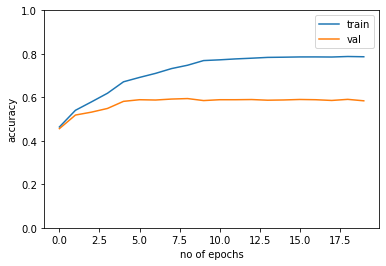

In [103]:
#plt.plot(training_loss)
plt.ylabel("accuracy")
plt.xlabel("no of epochs")
plt.plot(train_acc,label="train")
plt.plot(val_acc,label="val")
plt.legend(["train","val"])
plt.ylim((0,1))

<AxesSubplot:>

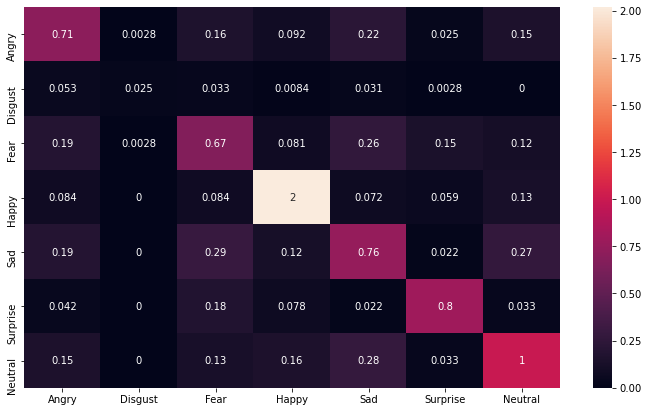

In [104]:
from sklearn.metrics import confusion_matrix
import seaborn as sn


y_pred = []
y_true = []

# iterate over test data
for inputs, labels in testloader:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth


# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

<AxesSubplot:>

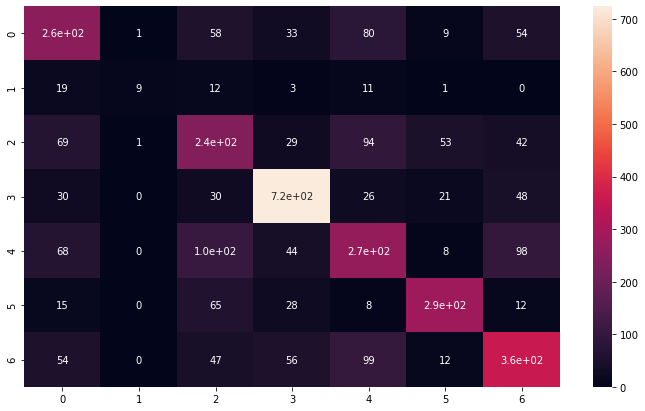

In [107]:
plt.figure(figsize = (12,7))
sn.heatmap(cf_matrix, annot=True)

In [105]:
cf_matrix

array([[256,   1,  58,  33,  80,   9,  54],
       [ 19,   9,  12,   3,  11,   1,   0],
       [ 69,   1, 240,  29,  94,  53,  42],
       [ 30,   0,  30, 724,  26,  21,  48],
       [ 68,   0, 105,  44, 271,   8,  98],
       [ 15,   0,  65,  28,   8, 288,  12],
       [ 54,   0,  47,  56,  99,  12, 358]], dtype=int64)